ADF Statistic for Production: 0.3670256852361496
p-value: 0.9802190475990149
ADF Statistic for SFS Price: -1.2387211773997462
p-value: 0.6567210892217452
ADF Statistic for SFS Stocks: -3.1765449390848546
p-value: 0.021383129955350234
ADF Statistic for Production: -8.450175274129567
p-value: 1.6706236954106548e-13
ADF Statistic for SFS Price: -4.943020115146045
p-value: 2.8738440594330407e-05
ADF Statistic for SFS Stocks: -15.594339472748512
p-value: 1.8630419992246529e-28
VAR Mean Squared Error: 1491152281.3888023
Next Month Forecast: 653528.6690558726


/Users/germankosenkov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


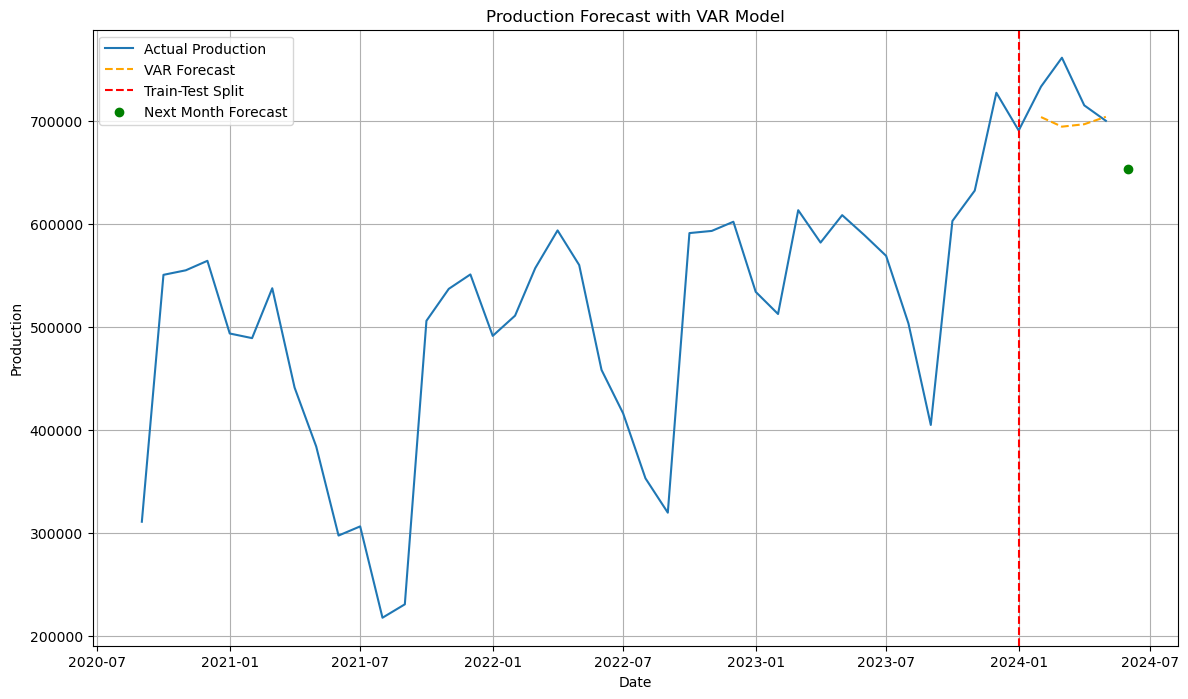

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

file_path = '/Users/germankosenkov/Desktop/XXXX SFO production modelling/Data/Raw Data/Merged.xlsx'
data = pd.read_excel(file_path)

data['date'] = pd.to_datetime(data['date'])

data.set_index('date', inplace=True)

# Function to perform Augmented Dickey-Fuller test
def adf_test(series, title=''):
    result = adfuller(series.dropna())
    print(f'ADF Statistic for {title}: {result[0]}')
    print(f'p-value: {result[1]}')

# Perform ADF test on each series
for column in data.columns:
    adf_test(data[column], title=column)

# Differencing the data to make it stationary if necessary
data_diff = data.diff().dropna()

# Check again for stationarity
for column in data_diff.columns:
    adf_test(data_diff[column], title=column)

# Split the data into training and test sets
train_size = 40
train, test = data_diff[:train_size], data_diff[train_size:]

# Fit the VAR model with adjusted maxlags
model = VAR(train)
var_model = model.fit(maxlags=5, ic='aic')

# Make forecasts
lag_order = var_model.k_ar
var_forecast = var_model.forecast(train.values[-lag_order:], steps=len(test))

# Convert forecasts to a DataFrame
forecast_df = pd.DataFrame(var_forecast, index=test.index, columns=train.columns)

# Reverse the differencing to get actual forecast values
def invert_transformation(train, forecast):
    forecast_values = forecast.copy()
    for col in train.columns:
        forecast_values[col] = train[col].iloc[-1] + forecast_values[col].cumsum()
    return forecast_values

forecast_values = invert_transformation(data[:train_size], forecast_df)

# Align lengths of actual and forecasted values for MSE calculation
test_aligned = data['Production'][train_size:train_size + len(forecast_values)]

# Calculate the mean squared error for the 'Production' column
var_mse = mean_squared_error(test_aligned, forecast_values['Production'])

# Forecast the next month using the VAR model
var_forecast_next = var_model.forecast(data_diff.values[-lag_order:], steps=1)
forecast_next_df = pd.DataFrame(var_forecast_next, columns=data_diff.columns)
forecast_next_values = invert_transformation(data, forecast_next_df)

# Print the results
print(f"VAR Mean Squared Error: {var_mse}")
print(f"Next Month Forecast: {forecast_next_values['Production'].iloc[-1]}")

# Plot the actual data, test data, and forecasted values
plt.figure(figsize=(14, 8))
plt.plot(data['Production'], label='Actual Production')
plt.plot(forecast_values.index, forecast_values['Production'], label='VAR Forecast', color='orange', linestyle='--')
plt.axvline(train.index[-1], color='r', linestyle='--', label='Train-Test Split')

# Correctly handle the date for the next month's forecast
next_month = data.index[-1] + pd.DateOffset(months=1)
plt.scatter(next_month, forecast_next_values['Production'].iloc[-1], color='green', label='Next Month Forecast')

plt.title('Production Forecast with VAR Model')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()

import pickle

# Save the fitted VAR model to a file
with open('var_model.pkl', 'wb') as f:
    pickle.dump(var_model, f)

